## Das sogenannte TSP-Problem

*Finding a shortest route has a large number of practical applications, e.g. navigation systems or the control of soldering robots.
The "Traveling Salesperson Problem" specifies a number of cities (nodes) connected by roads (edges). Your task is to develop an algorithm that visits all cities on the shortest possible route. Each city can be visited any number of times and every street can be used as often as you like.<br>
Cities are named with IDs from 0 ... N-1, where N is the number of cities. A tour always starts in the city with the ID 0 and ends there.*

Möglicherweise geeignete Algorithmen für das Problem:<br>
*Possibly suitable algorithms for the problem:*

* Brute force
* Greedy best-first search
* Simulated Annealing
* Genetic Algorithms
* Ant colony optimization

## Code

RangeIndex(start=0, stop=365, step=1)
365 cities ⇒ tour length 109882


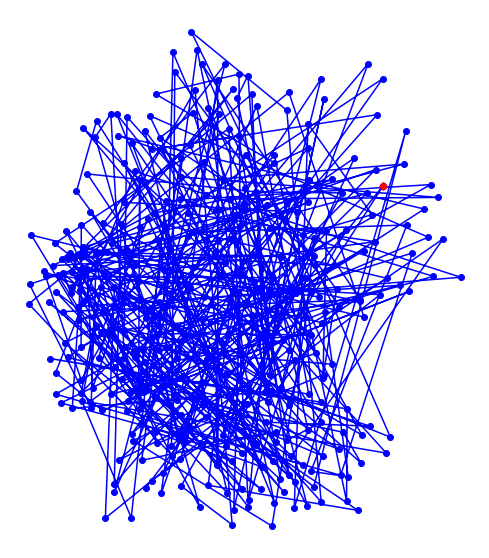

In [15]:
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from itertools import permutations
from random import shuffle, randrange
import pandas as pd


def tour_length(cities, tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(get_dist(cities, tour[i - 1], tour[i]) 
               for i in range(len(tour)))

def is_valid_tour(tour, gold):
    if (len(tour) != len(gold)):
        print("Not the same number of cities as in reference:", len(tour), len(gold))
        return False
    
    t1 = set(tour)
    t2 = set(gold)
    diff = t1 ^ t2
    if (len(diff) > 0):
        print("Spurious cities in tour:", diff)
        return False
    
    return True

def plot_tour(cities, tour, style='bo-'): 
    """Plot every city and link in the tour, and highlight start city."""
    print("{} cities ⇒ tour length {:.0f}".format(len(tour), tour_length(cities, tour)))

    plt.figure(figsize=(10,10))
    start = tour[0:1]
    plot_segment(cities, tour + start, style)
    plot_segment(cities, start, 'rD') # start city is red Diamond.
    
def plot_segment(cities, segment, style='bo-'):
    """Plot every city and link in the segment."""
    plt.plot([X(cities, i) for i in segment], [Y(cities, i)*1.4 for i in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('off')
    
def X(cities, i): 
    """X coordinate."""
    return cities.loc[i,'lng']

def Y(cities, i): 
    """Y coordinate."""
    return cities.loc[i,'lat']

def get_dist(cities, i, j):
    """Compute the distance between two citites from their longitude and latitude values"""

    lat1 = cities.loc[i,'lat']
    lng1 = cities.loc[i,'lng']
    lat2 = cities.loc[j,'lat']
    lng2 = cities.loc[j,'lng']
    
    r = 6371 # radius of the earth in km
    lat1=radians(lat1)
    lat2=radians(lat2)
    lat_dif=lat2-lat1
    lng_dif=radians(lng2-lng1)
    a=sin(lat_dif/2.0)**2+cos(lat1)*cos(lat2)*sin(lng_dif/2.0)**2
    d=2*r*asin(sqrt(a))
    
    return d

# data from https://simplemaps.com/data/de-cities
cities = pd.read_csv('data/tsp/de.csv')

tour = [x for x in list(cities.index.values)]


currently shortest: 108834
currently shortest: 107989
currently shortest: 107298
currently shortest: 106731
currently shortest: 106189
currently shortest: 105650
currently shortest: 105141
currently shortest: 104653
currently shortest: 104173
currently shortest: 103729
365 cities ⇒ tour length 103729


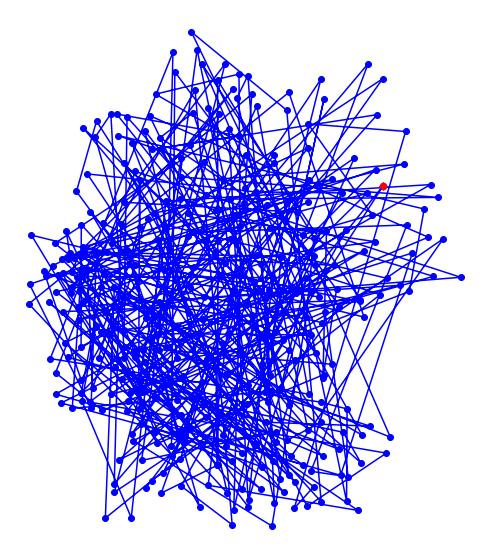

In [4]:
def uncrossing(cities, n):
    # start with random tour
    tour = [x for x in list(cities.index.values)]
    
    min_tour = tour
    min_tour_len = tour_length(cities, tour)
    # n rounds
    for i in range(n):
        tour = local_best(cities, min_tour)
        tour_len = tour_length(cities, tour)
        if tour_len < min_tour_len:
            min_tour_len = tour_len
            min_tour = list(tour)
            print("currently shortest: {:.0f}".format(min_tour_len))

    return min_tour

def local_best(cities, tour):
    min_tour = tour
    min_tour_len = tour_length(cities, tour)
    for i in range(len(tour)-1):
        # swap
        tour[i], tour[i+1] = tour[i+1], tour[i]
        tour_len = tour_length(cities, tour)
        if tour_len < min_tour_len:
            min_tour_len = tour_len
            min_tour = list(tour)
        # swap back
        tour[i], tour[i+1] = tour[i+1], tour[i]
            
    return min_tour
    
# new_tour = uncrossing(cities, 10)
# is_valid_tour(new_tour, tour)
# plot_tour(cities, new_tour)  

In [58]:
import random
import numpy as np

#Given from exercise with modification, swap 2 connection if it'll reduce the dist
def xyz(cities, n, tour):
    # start with random tour
    min_tour = tour
    min_tour_len = tour_length(cities, tour)
    # n rounds
    for i in range(n):
        tour = local_best(cities, min_tour)
        tour_len = tour_length(cities, tour)
        if tour_len < min_tour_len:
            min_tour_len = tour_len
            min_tour = list(tour)
            print("currently shortest: {:.0f}".format(min_tour_len))

    return min_tour

#Given from exercise
def local_best(cities, tour):
    min_tour = tour
    min_tour_len = tour_length(cities, tour)
    for i in range(len(tour)-1):
        # swap
        tour[i], tour[i+1] = tour[i+1], tour[i]
        tour_len = tour_length(cities, tour)
        if tour_len < min_tour_len:
            min_tour_len = tour_len
            min_tour = list(tour)
        # swap back
        tour[i], tour[i+1] = tour[i+1], tour[i]
            
    return min_tour

def initColony(cities, colony):
    for i in range(len(colony.keys())):
        colony[i]["path"] = [list(cities.index.values)[random.randint(0, len(cities))]]
    
def prob(cities, dist_matrix, pheromone, alpha, beta):
    # Calculate the probability to each points with the current pheromone level
    probabilities = pd.DataFrame(columns = list(cities.index), index = list(cities.index))
    
    for i in cities.index:
        for j in cities.index:
            if probabilities.iloc[i, j] is np.nan:
                probabilities.iloc[i, j] = ((pheromone.iloc[i, j])**alpha) * ((dist_matrix.iloc[i, j])**-beta)
                probabilities.iloc[j, i] = probabilities.iloc[i, j]
                
    return probabilities

def prob_ant(cities, pheromone, dist_matrix, unvisited, current, probabilities, alpha, beta):
    # Calculate the normalized probability for current ant.
    sigma = 0
    for c in unvisited:
        sigma += ((pheromone.iloc[current, c])**alpha) * ((dist_matrix.iloc[current, c])**-beta)
    ant_prob = probabilities.iloc[current, :] / sigma
    return pd.to_numeric(ant_prob)

def update_Pheromone(cities, pheromone, colony, Q, n_ants, decay):
    # update the pheromone matrix after all the ants found their path in the current iteration
    d = 0
    for i in range(n_ants):
        for j in range(len(colony[i]["path"]) - 1):
            src, dest = colony[i]["path"][j], colony[i]["path"][j + 1]
            pheromone.iloc[src, dest] += Q / colony[i]["dist"]
        d += Q / colony[i]["dist"]
    for i in cities.index:
        for j in cities.index:
            pheromone.iloc[i, j] = (1 - decay) * pheromone.iloc[i, j] * d
        
        
def aco(cities, n_ants = 10, n_iterations = 10, Q = 4, decay = 0.6, alpha = 1, beta = 2):
    """Ant colony optimization"""
    
    # Creating the distance matrix where indices are cities
    print("Initializing distance matrix...")
    dist_matrix = pd.DataFrame(columns = list(cities.index), index = list(cities.index))
    for i in cities.index:
        for j in cities.index:
            if dist_matrix.iloc[i, j] is np.nan:
                if i == j:
                    dist_matrix.iloc[i, j] = np.inf
                else:
                    dist_matrix.iloc[i, j] = get_dist(cities, i, j)
                    dist_matrix.iloc[j, i] = dist_matrix.iloc[i, j]
    global_best_path = {}            
    colony = {}
    num_cities = len(cities)
    
    print("Initializing ants...")
    
    for i in range(n_ants):
        colony[i] = {"path": [], "dist": 0}
        
    pheromone = pd.DataFrame(columns = list(cities.index), index = list(cities.index))
    
    print("Initializing Pheromone Matrix...")
    
    for i in cities.index:
        for j in cities.index:
            if pheromone.iloc[i, j] is np.nan:
                pheromone.iloc[i, j] = 1 / num_cities
                pheromone.iloc[j, i] = pheromone.iloc[i, j]
                
    for i in range(n_iterations):
        print(f"Starting iteration {i}")
        initColony(cities, colony)
        probabilities = prob(cities, dist_matrix, pheromone, alpha, beta)
        for ant in range(n_ants):
            unvisited = list(cities.index.values)
            current = colony[ant]["path"][0]
            unvisited.remove(current)
            for j in range(1, num_cities):
                if len(unvisited) > 1:
                    ant_prob = prob_ant(cities, pheromone, dist_matrix, unvisited, current, probabilities, alpha, beta)
                    current = ant_prob.iloc[unvisited].idxmax(0)
                    unvisited.remove(current)
                    colony[ant]["path"].append(current)
                    
                else:
                    colony[ant]["path"].append(unvisited[0])
                    
            colony[ant]["dist"] = tour_length(cities, colony[ant]["path"])
        
        update_Pheromone(cities, pheromone, colony, Q, n_ants, decay) 
        local_best_index = min(colony, key = (lambda key: colony[key]["dist"]))
        local_best_path = dict(colony[local_best_index])
        if i == 0:
            print("default change")
            global_best_path = local_best_path
        else:
            if local_best_path["dist"] < global_best_path["dist"]:
                print(global_best_path["dist"])
                print("Global is larger changing value")
                global_best_path = local_best_path
                
        g_best_dist = global_best_path["dist"]
        best_dist = local_best_path["dist"]
        print(f"Iteration {i+1} -> distance: {best_dist}, current best: {g_best_dist}")
    g_best_path = local_best_path["path"]
    g_best_dist = local_best_path["dist"]
    print(f"Global best path is {global_best_path}, with distance: {g_best_dist}")
    return global_best_path["path"]

In [60]:
# cities =  pd.read_csv('data/tsp/de.csv')
new_tour = aco(cities, n_ants = len(cities) // 10)
new_enhanced_tour = uncrossing(cities, len(cities) // 10 , new_tour)
is_valid_tour(new_enhanced_tour, tour)
plot_tour(cities, new_enhanced_tour) 


Initializing distance matrix...
Initializing ants...
Initializing Pheromone Matrix...
Starting iteration 0


KeyboardInterrupt: 

<div class="task_description">
    <i class="task">Homework 2.3:</i>
        :::1 Extra-Klausurbonuspunkt :::</div>
Ein Extra-Klausurbonuspunkt wird an die fünf bestplazierten Teams vergeben, Ziel ist es eine möglichst geringe Fahrtzeit zu erreichen. Die Endergebnisse werden auf Moodle präsentiert.

*An additional exam bonus point is awarded to the five best placed teams with the aim of achieving the shortest possible driving time. The final results will be presented on Moodle.*